In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
from iSDR_cython import linear_model
from scipy.io import loadmat
np.random.seed(12)

In this notebook, we show an example on how to run eISDR and its old version iSDR that is presented in:
    
    (1) Brahim Belaoucha, Théodore Papadopoulo. Large brain effective network from EEG/MEG data and dMR information. PRNI 2017 – 7th International Workshop on Pattern Recognition in NeuroImaging, Jun 2017, Toronto, Canada.

    (2) Brahim Belaoucha, Mouloud Kachouane, Théodore Papadopoulo. Multivariate Autoregressive Model Constrained by Anatomical Connectivity to Reconstruct Focal Sources. 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), Aug 2016, Orlando, United States. 2016.

We show how you can run both using real and synthetic data

# Define sensor and source space

In [2]:
n_t = 200
n_c, n_s = 3,3
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:3, 0] = [10, 0.1, 0]
A = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0.5,0,0.5]])
for i in range(J.shape[-1]-1):
    J[:3, i+1] = np.dot(A, J[:3, i])

print(A)


[[ 0.9  -0.4   0.  ]
 [ 0.25  0.97  0.  ]
 [ 0.5   0.    0.5 ]]


# Ground truth

(0, 200)

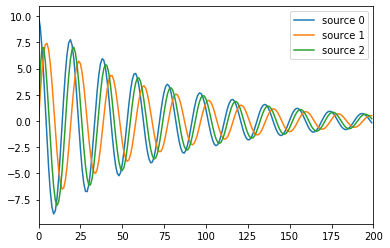

In [3]:
plt.plot(J.T)
plt.legend(['source %s'%s for s in range(n_s)])
plt.xlim(0, n_t)

# Define the structural connectivity

In [4]:
SC = np.array([[1,1,1], [1,1,0],[1,0,1]])
print( SC)

[[1 1 1]
 [1 1 0]
 [1 0 1]]


# Example 1: eiSDR order 1

## Generate EEG/MEG data

In [5]:
m_p = 1
M = np.dot(G, J[:, m_p:])

## Run eiSDR

In [6]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=[1e-2, 0.69], verbose=1, old_version=0,
                             normalize_Sstep=True, normalize_Astep=True)
cl.solver(G, M, SC, nbr_iter=10, model_p=1, A=np.eye(n_s), S_tol=1e-3, normalize=0)
R = cl.Scoef_
cl.xscale

Iteration 1: nbr of active sources 3
Iteration 2: nbr of active sources 3
Stopped at iteration 2 : Change in active set tol 3.0000 > 3.0000  


array([[0.6725813 ],
       [0.81123793],
       [0.05267249]])

In [7]:
cl.a_dualgap, cl.s_dualgap

([None], [0.007429175846960304, 0.01025545932894538])

## Get eigenvalues of MVAR model

In [8]:
cl.get_phi()
cl.eigs

,real,imag,abs
eig,,,
eig_0,0.482651,0.000000,0.482651
eig_1,0.938426,0.313369,0.989365
eig_2,0.938426,-0.313369,0.989365


## Plot effective connectivity

Execution time 0.025 sec


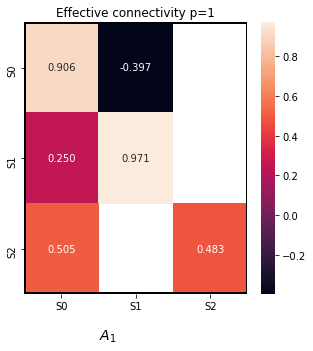

In [9]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

## Reconstruct the brain activation

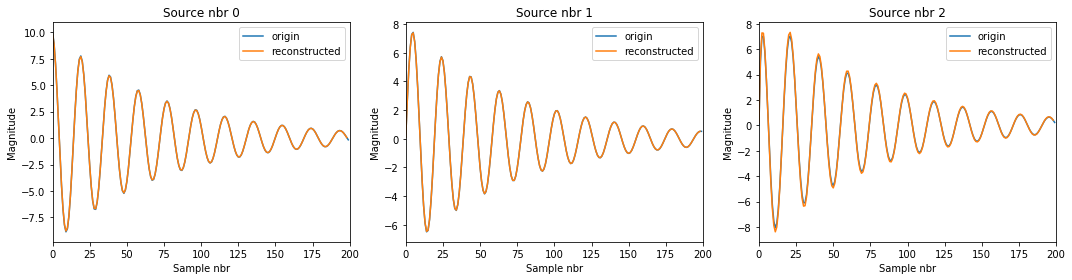

In [10]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p-1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [11]:
for i in range(m_p, n_t - m_p):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

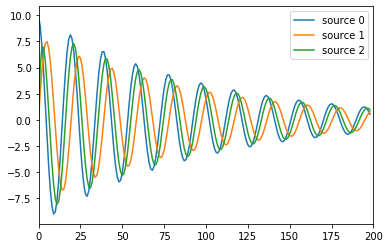

In [12]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Example 2: eiSDR order 3

## Initialize MVAR model

In [13]:
m_p = 3
Atmp = np.zeros((n_s, n_s*m_p))
Atmp[:, -n_s:] = np.eye(n_s)

## Run eiSDR

In [14]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.001, la=[1e-4, 1.], verbose=True, old_version=0, normalize_Sstep=True,
                             normalize_Astep=False)
cl.solver(G, M, SC, nbr_iter=10, model_p=m_p, A=Atmp)
R = cl.Scoef_


Iteration 1: nbr of active sources 3
Iteration 2: nbr of active sources 3
Stopped at iteration 2 : Change in active set tol 3.0000 > 3.0000  


## Compute eigenvalues of MVAR model

In [15]:
cl.get_phi()
cl.eigs

,real,imag,abs
eig,,,
eig_0,0.935053,0.314314,0.986467
eig_1,0.935053,-0.314314,0.986467
eig_2,-0.214820,0.967442,0.991006
eig_3,-0.214820,-0.967442,0.991006
eig_4,-0.722010,0.653417,0.973782
eig_5,-0.722010,-0.653417,0.973782
eig_6,0.235826,0.528915,0.579107
eig_7,0.235826,-0.528915,0.579107
eig_8,-0.515692,0.000000,0.515692


## Plot effective connectivity

Execution time 0.112 sec


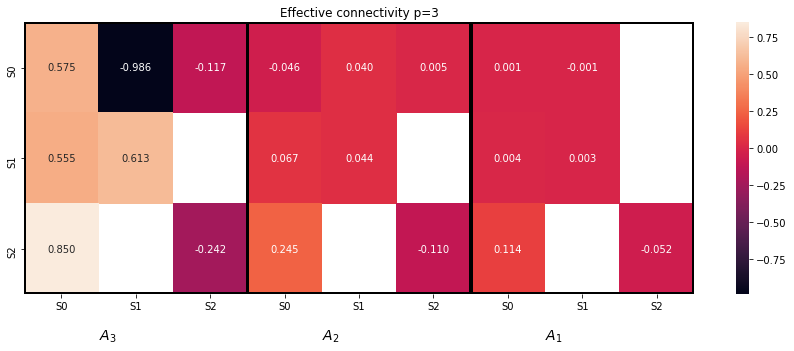

In [16]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

## Reconstruct the brain activation

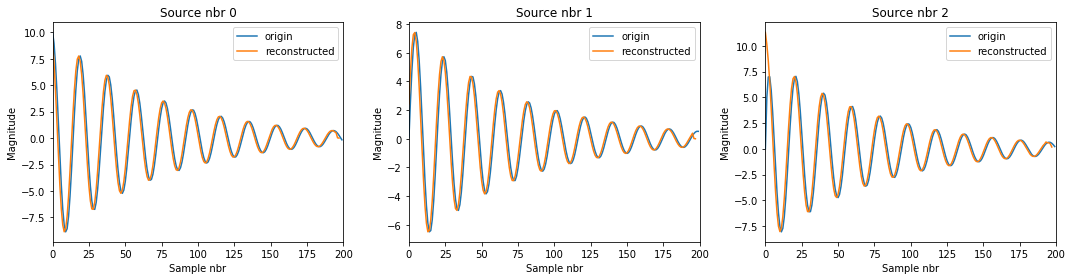

In [17]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [18]:
for i in range(m_p, R.shape[1]):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

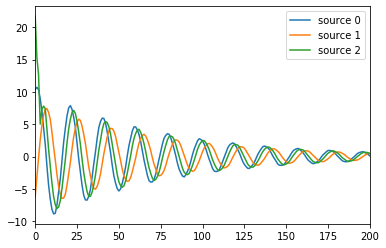

In [19]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Cross-validation eiSDR:  grid-search

## Load eiSDRcv

In [7]:
from iSDR_cython import linear_model

In [8]:
clf = linear_model.iSDRcv(l21_values=[10**-i for i in range(-1, 6, 1)],
                          la_values=[10**-i for i in range(-1, 5,1)], la_ratio_values=[1, 0.5, 0.75, 0.25],
                          normalize=[0, 1],
                          model_p=[1,2],
                         old_version=False,
                          normalize_Astep=[0],
                          normalize_Sstep=[1],
                          cv=3
                         )

## Created random folder

In [9]:
clf.foldername

'/tmp/tmp_796ffece-5f37-4ac5-81c8-8be3bc2c7d46'

## Run grid cross validation

In [10]:
clf.run(G, M, SC)

## Results

In [24]:
print('Execution time %.3f sec'%clf.time)
df = clf.results

Execution time 93.288 sec


In [25]:
df.Obj.min()

0.22108936054271972

## Parameters resulting to smallest Obj

In [40]:
x  = df[df.Obj == df.Obj.min()]

In [41]:
x

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,normalize_Astep,normalize_Sstep,Obj
588,0.2006,3.0,148.725918,3.0,2.088205,0.00001,0.01,0.25,1,1,0.000035,0,1,0.221089


## Reconstruct with optimal parameters

In [42]:
cl = ciSDR.linear_model.iSDR(l21_ratio=x.ls_reg.values[0], la=[x.la_reg_a.values[0], x.la_reg_r.values[0]],
                             old_version=False, normalize_Astep=x.normalize_Astep.values[0],
                            normalize_Sstep=x.normalize_Sstep.values[0])
cl.solver(G, M, SC, nbr_iter=10, model_p=x.p.values[0], A=np.eye(n_s))
R = cl.Scoef_

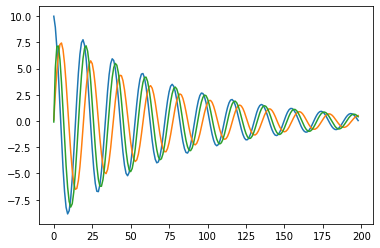

In [43]:
cl.bias_correction()
plt.plot(cl.Jbias_corr.T)

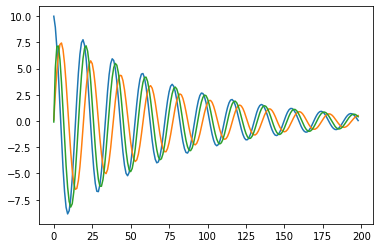

In [44]:
plt.plot(cl.Scoef_.T)

## Reconstructed effective connectivity

Execution time 0.043 sec


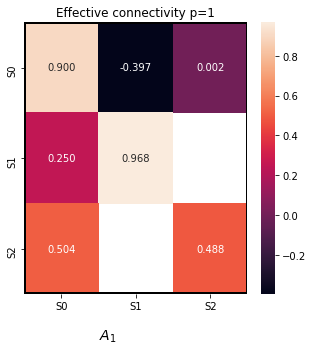

In [45]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

## Reconstructed dynamics

In [46]:
cl.get_phi()
cl.eigs

,real,imag,abs
eig,,,
eig_0,0.487048,0.000000,0.487048
eig_1,0.934683,0.312731,0.985613
eig_2,0.934683,-0.312731,0.985613


# Real data

We are using EEG data acquired during famous face recognition task. we should see an activation around 170 ms in the fusiform area

## Load data 

In [2]:
data = loadmat('S1_EEG.mat')

## Run eiSDRols

In [16]:
cl = ciSDR.linear_model.eiSDRols(l21_ratio=10, la=[1, 1], verbose=1)
cl.solver(data['G'], data['M'], data['SC'].astype(int), model_p=1)

Iteration 1: nbr of active sources 89
Iteration 2: nbr of active sources 48
Iteration 3: nbr of active sources 42
Iteration 4: nbr of active sources 41
Iteration 5: nbr of active sources 39
Iteration 6: nbr of active sources 39
Stopped at iteration 6 : Change in active set tol 39.0000 > 39.0000  


## Reconstructed brain activation

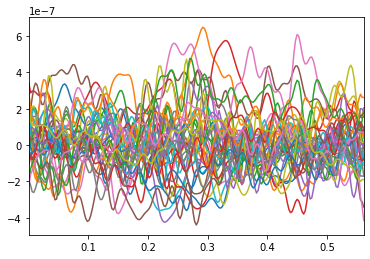

In [33]:
time_samples = data['time'][0][:cl.Scoef_.shape[1]]
plt.plot(time_samples, cl.Scoef_.T);
plt.xlim(time_samples.min(), time_samples.max());

## Effective connectivity

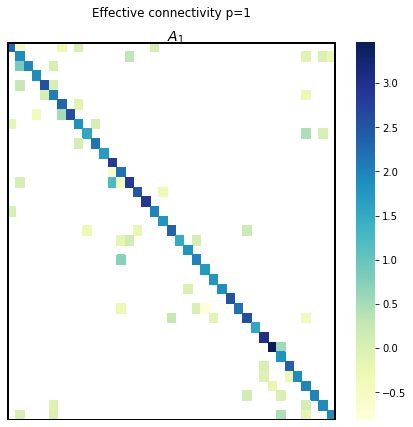

In [18]:
cl.plot_effective(fig_size=6, annot=False, cmap="YlGnBu")

## Fushiform area activation

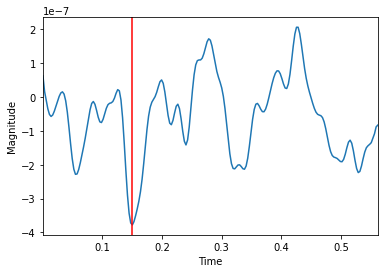

In [34]:
ix = np.where(cl.active_set[-1] == 42)[0][0]
plt.plot(time_samples, cl.Scoef_[ix, :])
x_arg = np.argmin(cl.Scoef_[ix, :])
plt.axvline(x=time_samples[x_arg], c='r')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.xlim(time_samples.min(), time_samples.max());

In [35]:
print('Activation at right fusiform area is detected at %.3f s'%(time_samples[x_arg]))

Activation at right fusiform area is detected at 0.150 s
